# Post-Estimation Tutorial

In [1]:
%matplotlib inline

import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'0.6.1'

This tutorial covers several features of `pyblp` which are available after estimation including:

1. Calculating elasticities and diversion ratios.
2. Calculating marginal costs and markups.
3. Computing the effects of mergers: prices, shares, and HHI.
4. Using a parametric bootstrap to estimate standard errors.
5. Estimating optimal instruments.


## Problem Results

As in the [fake cereal tutorial](nevo.ipynb), we'll first solve the fake cereal problem from :ref:`references:Nevo (2000)`. We load the fake data and estimate the model as in the previous tutorial. We output the setup of the model to confirm we have correctly configured the :class:`Problem`

In [2]:
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
agent_data = pd.read_csv(pyblp.data.NEVO_AGENTS_LOCATION)
product_formulations = (
   pyblp.Formulation('0 + prices', absorb='C(product_ids)'),
   pyblp.Formulation('1 + prices + sugar + mushy')
)
agent_formulation = pyblp.Formulation('0 + income + income_squared + age + child')
problem = pyblp.Problem(product_formulations, product_data, agent_formulation, agent_data)
problem

Dimensions:
 N     T    K1    K2    D    MD    ED 
----  ---  ----  ----  ---  ----  ----
2256  94    1     4     4    20    1  

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics    1         prices      sugar  mushy
       d: Demographics         income  income_squared   age   child

We'll solve the problem in the same way as before. The :meth:`Problem.solve` method returns a :meth:`ProblemResults` class, which displays basic estimation results. The results that are displayed are simply formatted information extracted from various class attributes such as :attr:`ProblemResults.sigma` and :attr:`ProblemResults.sigma_se`.

In [3]:
initial_sigma = np.diag([0.3302, 2.4526, 0.0163, 0.2441])
initial_pi = [
  [ 5.4819,  0,      0.2037,  0     ],
  [15.8935, -1.2000, 0,       2.6342],
  [-0.2506,  0,      0.0511,  0     ],
  [ 1.2650,  0,     -0.8091,  0     ]
]
bfgs = pyblp.Optimization('bfgs')
results = problem.solve(
    initial_sigma,
    initial_pi,
    optimization=bfgs,
    method='1s'
)
results

Problem Results Summary:
                   Cumulative    Cumulative     Final    Cumulative   Cumulative   Gradient
Cumulative  GMM   Optimization  Optimization  Objective  Fixed Point  Contraction  Infinity
   Time     Step   Iterations   Evaluations     Value    Iterations   Evaluations    Norm  
----------  ----  ------------  ------------  ---------  -----------  -----------  --------
 0:00:30     1         51            58       +4.6E+00      46236       143503     +6.9E-06

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  ----------  |  ------  ----------  --------------  ----------  ----------
  1      +5.6E-01    +0.0E+00    +0.0E+00    +0.0E+00   |    1      +2.3E+00      +0.0E+00      +1.3E+00    +0.0E+00 
        (+1.6E-01)                                      |          (+1.2E+00)                  (+6.

Additional post-estimation outputs can be computed with :class:`ProblemResults` methods.


## Elasticities and Diversion Ratios

We can estimate elasticities, $\varepsilon$, and diversion ratios, $\mathscr{D}$, with :meth:`ProblemResults.compute_elasticities` and :meth:`ProblemResults.compute_diversion_ratios`.

As a reminder, elasticities in each market are

$$\varepsilon_{jk} = \frac{x_k}{s_j}\frac{\partial s_j}{\partial x_k}.$$

Diversion ratios are

$$\mathscr{D}_{jk} = -\frac{\partial s_k / \partial x_j}{\partial s_j / \partial x_j}.$$

Following :ref:`references:Conlon and Mortimer (2018)`, we report the diversion to the outside good $D_{j0}$ on the diagonal instead of $D_{jj}=-1$.

In [4]:
elasticities = results.compute_elasticities()
diversions = results.compute_diversion_ratios()

Post-estimation outputs are computed for each market and stacked. We'll use [matplotlib](https://matplotlib.org/) functions to display the matrices associated with a single market.

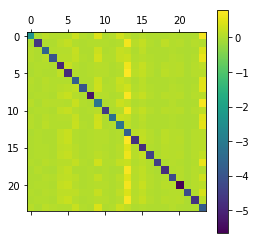

In [5]:
single_market = product_data['market_ids'] == 'C01Q1'
plt.colorbar(plt.matshow(elasticities[single_market]));

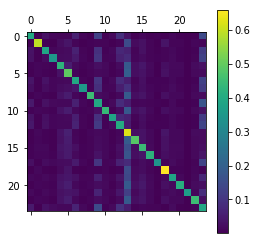

In [6]:
plt.colorbar(plt.matshow(diversions[single_market]));

The diagonal of the first image consists of own elasticities and the diagonal of the second image consists of diversion ratios to the outside good. As one might expect, own price elasticities are large and negative while cross-price elasticities are positive but much smaller.

Elasticities and diversion ratios can be computed with respect to variables other than `prices` with the `name` argument of :meth:`ProblemResults.compute_elasticities` and :meth:`ProblemResults.compute_diversion_ratios`. Additionally, :meth:`ProblemResults.compute_long_run_diversion_ratios` can be used to used to understand substitution when products are eliminated from the choice set.

The convenience methods :meth:`ProblemResults.extract_diagonals` and :meth:`ProblemResults.extract_diagonal_means` can be used to extract information about own elasticities of demand from elasticity matrices.

In [7]:
means = results.extract_diagonal_means(elasticities)

An alternative to summarizing full elasticity matrices is to use :meth:`ProblemResults.compute_aggregate_elasticities` to estimate aggregate elasticities of demand, $E$, in each market, which reflect the change in total sales under a proportional sales tax of some factor.

In [8]:
aggregates = results.compute_aggregate_elasticities(factor=0.1)

Since demand for an entire product category is generally less elastic than the average elasticity of individual products, mean own elasticities are generally larger in magnitude than aggregate elasticities.

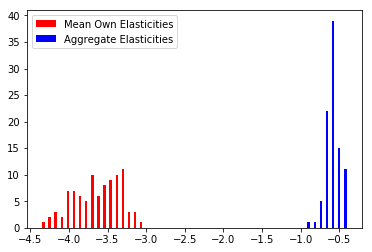

In [9]:
plt.hist(
    [means.flatten(), aggregates.flatten()], 
    color=['red', 'blue'], 
    bins=50
);
plt.legend(['Mean Own Elasticities', 'Aggregate Elasticities']);

## Marginal Costs and Markups

To compute marginal costs, $c$, the `product_data` passed to :class:`Problem` must have had a `firm_ids` field. Since we included firm IDs when configuring the problem, we can use :meth:`ProblemResults.compute_costs`.

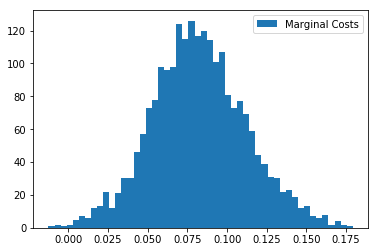

In [10]:
costs = results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

Other methods that compute supply-side outputs often compute marginal costs themselves. For example, :meth:`ProblemResults.compute_markups` will compute marginal costs when estimating markups, $\mathscr{M}$, but computation can be sped up if we just use our pre-computed values.

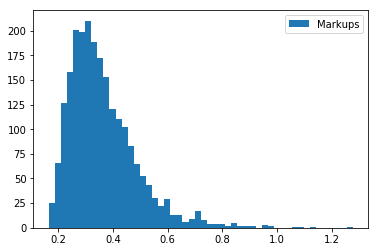

In [11]:
markups = results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

## Mergers

Before computing post-merger outputs, we'll supplement our pre-merger markups with some other outputs. We'll compute Herfindahl-Hirschman Indices, $\text{HHI}$, with :meth:`ProblemResults.compute_hhi`; population-normalized gross expected profits, $\pi$, with :meth:`ProblemResults.compute_profits`; and population-normalized consumer surpluses, $\text{CS}$, with :meth:`ProblemResults.compute_consumer_surpluses`.

In [12]:
hhi = results.compute_hhi()
profits = results.compute_profits(costs=costs)
cs = results.compute_consumer_surpluses()

To compute post-merger outputs, the `firm_ids` field in the `product_data` passed to :class:`Problem` must have had at least two columns. Columns after the first represent changes, such as mergers. Although mergers are commonly what firm ID changes represent, these additional columns can represent any type of change.

Since we included two columns of firm IDs when configuring the problem, we can use :meth:`ProblemResults.compute_approximate_prices` or :meth:`ProblemResults.compute_prices` to estimate post-merger prices. The first method, which is discussed, for example, in :ref:`references:Nevo (1997)`, assumes that shares and their price derivatives are unaffected by the merger. The second method does not make these assumptions and iterates over the $\zeta$-markup equation from :ref:`references:Morrow and Skerlos (2011)` to solve the full system of $J_t$ equations and $J_t$ unknowns in each market $t$. We'll use the latter, since it is fast enough for this example problem.

In [13]:
changed_prices = results.compute_prices(costs=costs)

If the problem was configured with more than two columns of firm IDs, we could estimate post-merger prices for the other mergers with the `firms_index` argument, which is by default `1`.

We'll compute post-merger shares with :meth:`ProblemResults.compute_shares`.

In [14]:
changed_shares = results.compute_shares(changed_prices)

Post-merger prices and shares are used to compute other post-merger outputs. For example, $\text{HHI}$ increases.

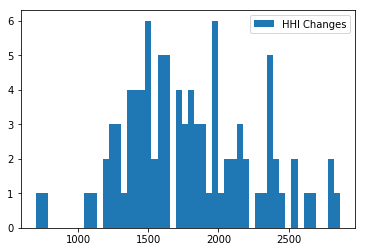

In [15]:
changed_hhi = results.compute_hhi(firms_index=1, shares=changed_shares)
plt.hist(changed_hhi - hhi, bins=50);
plt.legend(["HHI Changes"]);

Markups, $\mathscr{M}$, and profits, $\pi$, generally increase as well.

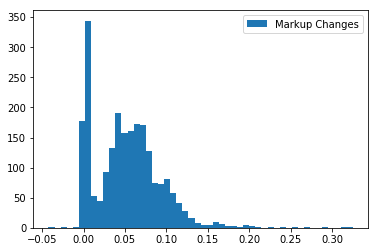

In [16]:
changed_markups = results.compute_markups(changed_prices, costs)
plt.hist(changed_markups - markups, bins=50);
plt.legend(["Markup Changes"]);

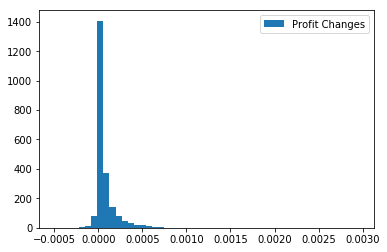

In [17]:
changed_profits = results.compute_profits(changed_prices, changed_shares, costs)
plt.hist(changed_profits - profits, bins=50);
plt.legend(["Profit Changes"]);

On the other hand, consumer surpluses, $\text{CS}$, generally decrease.

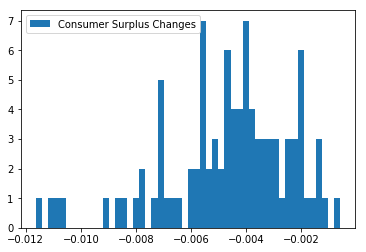

In [18]:
changed_cs = results.compute_consumer_surpluses(changed_prices)
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

## Bootstrapping Results

Post-estimation outputs can be informative, but they don't mean much without a sense sample-to-sample variability. One way to estimate confidence intervals for post-estimation outputs is with a standard bootstrap procedure:

1. Construct a large number of bootstrap samples by sampling with replacement from the original product data.
2. Initialize and solve a :class:`Problem` for each bootstrap sample.
3. Compute the desired post-estimation output for each bootstrapped :class:`ProblemResults` and from the resulting empirical distribution, construct boostrap confidence intervals.

Although appealing because of its simplicity, the computational resources required for this procedure are often prohibatively expensive. Furthermore, human oversight of the optimization routine is often required to determine whether the routine ran into any problems and if it successfully converged. Human oversight of estimation for each bootstrapped problem is usually not feasible.

A more reasonable alternative is a parametric bootstrap procedure:

1. Construct a large number of draws from the estimated joint distribution of parameters.
2. Compute the implied mean utility, $\delta$, and shares, $s$, for each draw. If a supply side was estimated, also computed the implied marginal costs, $c$, and prices, $p$.
3. Compute the desired post-estimation output under each of these parametric bootstrap samples. Again, from the resulting empirical distribution, construct boostrap confidence intervals.

Compared to the standard bootstrap procedure, the parametric bootstrap requires far fewer computational resources, and is simple enough to not require human oversight of each bootstrap iteration. The primary complication to this procedure is that when supply is estimated, equilibrium prices and shares need to be computed for each parametric bootstrap sample by iterating over the $\zeta$-markup equation from :ref:`references:Morrow and Skerlos (2011)`. Although nontrivial, this fixed point iteration problem is much less demanding than the full optimization routine required to solve the BLP problem from the start.

An empirical distribution of results computed according to this parametric bootstrap procedure can be created with the :meth:`ProblemResults.bootstrap` method, which returns a :class:`BootstrappedResults` class that can be used just like :class:`ProblemResults` to compute various post-estimation outputs. The difference is that :class:`BootstrappedResults` methods return arrays with an extra first dimension, along which bootstrapped results are stacked.

We'll construct 90% parametric bootstrap confidence intervals for estimated aggregate elasticities in each market of the fake cereal problem. Usually, bootstrapped confidence intervals should be based on thousands of draws, but we'll only use a few for the sake of speed in this example.

In [19]:
bootstrapped_results = results.bootstrap(draws=100, seed=0)
bootstrapped_results

Bootstrapped Problem Results Summary:
Computation  Bootstrap
   Time        Draws  
-----------  ---------
  0:00:15       100   

In [20]:
bounds = np.percentile(
    bootstrapped_results.compute_aggregate_elasticities(), 
    q=[10, 90], 
    axis=0
)
table = pd.DataFrame(index=problem.unique_market_ids, data={
    'Lower Bound': bounds[0].flatten(), 
    'Aggregate Elasticity': aggregates.flatten(), 
    'Upper Bound': bounds[1].flatten()
})
table.round(2).head(10)

,Lower Bound,Aggregate Elasticity,Upper Bound
C01Q1,-0.54,-0.81,0.00
C01Q2,-0.28,-0.69,0.00
C03Q1,-0.30,-0.55,0.00
C03Q2,-0.38,-0.60,0.00
C04Q1,-0.26,-0.68,0.03
C04Q2,-0.33,-0.71,0.00
C05Q1,-0.29,-0.62,0.09
C05Q2,-0.35,-0.60,0.02
C07Q1,-0.22,-0.56,0.16
C07Q2,-0.27,-0.52,0.05


## Optimal Instruments

Given a consistent estimate of $\theta$, we may want to compute the optimal instruments of :ref:`references:Chamberlain (1987)` and use them to re-solve the problem. Optimal instruments have been shown, for example, by :ref:`references:Reynaert and Verboven (2014)`, to reduce bias, improve efficiency, and enhance stability of BLP estimates.

The :meth:`ProblemResults.compute_optimal_instruments` method computes the expected Jacobians that comprise the optimal instruments by integrating over the density of $\xi$ (and $\omega$ if a supply side was estimated). By default, the method approximates this integral by averaging over the Jacobian realizations computed under draws from the asymptotic normal distribution of the error terms. Since this process is computationally expensive and often doesn't make much of a difference, we'll use `method='approximate'` in this example to simply evaluate the Jacobians at the expected value of $\xi$, zero.

In [21]:
instrument_results = results.compute_optimal_instruments(method='approximate')
instrument_results

Optimal Instrument Results Summary:
Computation  Error Term
   Time        Draws   
-----------  ----------
  0:00:00        1     

We can use the :meth:`OptimalInstrumentResults.to_problem` method to re-create the fake cereal problem with the estimated optimal excluded instruments.

In [22]:
updated_problem = instrument_results.to_problem()
updated_problem

Dimensions:
 N     T    K1    K2    D    MD    ED 
----  ---  ----  ----  ---  ----  ----
2256  94    1     4     4    14    1  

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics    1         prices      sugar  mushy
       d: Demographics         income  income_squared   age   child

We can solve this updated problem just like the original one. We'll start at our consistent estimate of $\theta$.

In [23]:
updated_results = updated_problem.solve(
    results.sigma,
    results.pi, 
    optimization=pyblp.Optimization('bfgs'),
    method='1s'
)
updated_results

Problem Results Summary:
                   Cumulative    Cumulative     Final    Cumulative   Cumulative   Gradient
Cumulative  GMM   Optimization  Optimization  Objective  Fixed Point  Contraction  Infinity
   Time     Step   Iterations   Evaluations     Value    Iterations   Evaluations    Norm  
----------  ----  ------------  ------------  ---------  -----------  -----------  --------
 0:00:28     1         42            51       +8.0E-14      46008       142491     +3.0E-06

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  ----------  |  ------  ----------  --------------  ----------  ----------
  1      +2.1E-01    +0.0E+00    +0.0E+00    +0.0E+00   |    1      +6.0E+00      +0.0E+00      +1.6E-01    +0.0E+00 
        (+7.8E-02)                                      |          (+5.2E-01)                  (+2.